#Setting

In [ ]:
! pip install d2l

In [46]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
from torch import nn

d2l.use_svg_display()

# SoftMax Regression

## Image Classification Dataset

link : https://pytorch.org/vision/stable/datasets.html

### pytorch **Street View House Numbers** Data set

link :http://ufldl.stanford.edu/housenumbers/

RGB 3차원 데이터 셋


In [9]:
trans = transforms.ToTensor() # image 를 PIL type으로 바꿔준다.

train = torchvision.datasets.SVHN(root = "../data" , split = "train", 
                                          transform = trans, download = True)
test = torchvision.datasets.SVHN(root = "../data" , split = "test", 
                                          transform = trans, download = True)


Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


In [12]:
train[0][0].shape

torch.Size([3, 32, 32])

In [32]:
len(train), len(test)

(73257, 26032)

In [20]:
def show_images_3D(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            img = img.numpy()
            ax.imshow(np.transpose(img,(1,2,0))) # (32,32,3)
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

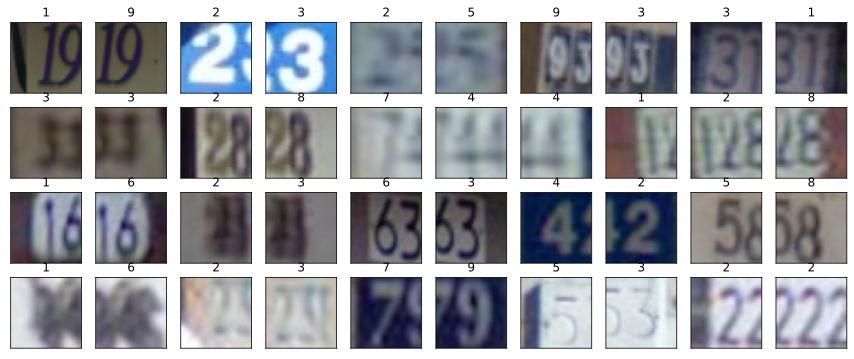

In [90]:
X,y = next(iter(data.DataLoader(train, batch_size = 40)))
show_images_3D(X, 4, 10, titles = [int(i) for i in y])
plt.show()

In [22]:
def get_dataloader_workers(): ## 병렬 processing to read the data
  return 4

def load_data_SVHN(batch_size, resize = None):

  trans = [transforms.ToTensor()]
  if resize:
        trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  train = torchvision.datasets.SVHN(root = "../data" , split = "train", 
                                          transform = trans, download = True)
  test = torchvision.datasets.SVHN(root = "../data" , split = "test", 
                                          transform = trans, download = True)
  
  return (data.DataLoader(train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [80]:
batch_size = 256
train_iter, test_iter = load_data_SVHN(batch_size)
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  print(X.min(), X.max())
  break

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 32, 32]) torch.float32 torch.Size([256]) torch.int64
tensor(0.) tensor(1.)


####modeling

In [65]:
#initailization
num_inputs = 3*32*32
num_outputs = 10

W = torch.normal(0,0.01, size = (num_inputs, num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad = True)

In [66]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1,keepdim = True)

  return X_exp / partition

def net(X):
  return softmax(torch.matmul(X.reshape((-1,W.shape[0])), W)+b) # reshape 조심

def cross_entropy(y_hat, y):
  return -torch.log(y_hat[range(len(y_hat)),y])
    #여기서 y_hat은 확률값(softmax 결과값)
    #정답에 해당하는 -log값
    #이후 다 더할 것임

In [67]:
def accuracy(y_hat, y):

  if len(y_hat.shape) > 1 and y_hat.shape[1] >1: #2차원에 각 label에 대한 확률 값이 있음을 확신
    y_hat = y_hat.argmax(axis = 1) #제일 높은 값의 index

  cmp = y_hat.type(y.dtype) == y # compare class : dtype 맞추면서
  return float(cmp.type(y.dtype).sum()) #맞는 개수 세기

class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]



def evaluate_accuracy(net, data_iter):

  if isinstance(net, torch.nn.Module):
    net.eval() # setting model to evaluation mode
  
  metric = Accumulator(2) 
  #two variables
  # number of correct predictions / number of predictions
  #accumulate sums over multiple variables

  with torch.no_grad():
    for X, y  in data_iter:
      
      metric.add(accuracy(net(X), y), y.numel())

  return metric[0] / metric[1] #최종 accuracy 평균값을 반환

####Training

In [68]:
def train_epoch_ch3(net, train_iter, loss, updater):

  if isinstance(net, torch.nn.Module):
    net.train() # set train mode

  #sum of training loss / sum of trainig accruacy // number of examples
  metric = Accumulator(3)

  for X, y in  train_iter:

    ## permuting 3D image
    X = X.permute(0,2,3,1)
    
    #Compute gradients and update parameter
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):

      #backpropagation
      updater.zero_grad() # batch 돌때마다 가중치 변화도 초기화
      l.mean().backward()
      updater.step()

    else: # using custom built optimizer and loss criterion
      l.sum().backward()
      updater(X.shape[0])
    
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    #return trainig loss and training accuracy

    return metric[0] / metric[2], metric[1] / metric[2]

In [69]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [70]:
def train_ch3(net, trian_iter, test_iter, loss, num_epochs, updater):

  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
  
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, trian_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch +1, train_metrics + (test_acc,))
  
  train_loss, train_acc= train_metrics

  #조건 반환 문
  # assert train_loss < 0.5, train_loss
  # assert train_acc <=1 and train_acc >0.7, train_acc
  # assert test_acc<=1 and test_acc>0.7, test_acc
  print(train_loss, train_acc)
  

In [71]:

lr = 0.2

def updater(batch_size):
  return d2l.sgd([W,b], lr, batch_size)

nan 0.078125


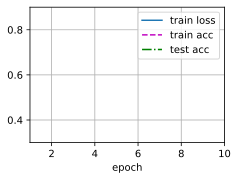

In [72]:
num_epochs = 10

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [44]:
W

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], requires_grad=True)

학습이 전혀 안되는 모습?

####API

In [47]:
net = nn.Sequential(nn.Flatten(), nn.Linear(3*64*64, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

In [48]:
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.2)

AssertionError: ignored

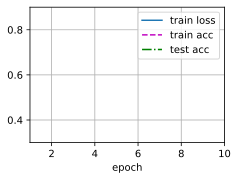

In [49]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

train loss가 0.5 넘겨서 error raise

마찬가지로 학습이 안되는 상태

사실상 softmax regression은 1 layer 모델이라 그런 것 같다.

별도의 feature extraction 과정이 없다. 

2, 3을 구별 할 때, 윤곽으로 데이터를 구별할 뿐 만 아니라, 색깔을 통해 구별해야하나

1 layer로는 부족하다

애초에 흑백 사진으로 바꾸면 어떻게 될까?

RGB 차원을 줄여서 흑백 사진으로 만들고 학습해보자

In [99]:
batch_size = 300
train_iter, test_iter = load_data_SVHN(batch_size)

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


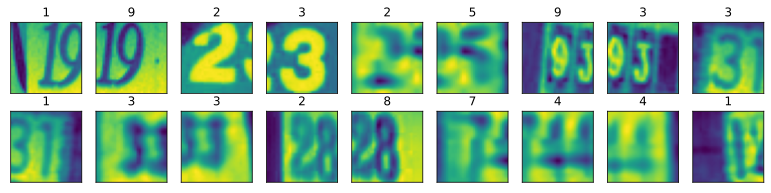

In [92]:
X,y = next(iter(data.DataLoader(train, batch_size = 18)))
X = X.sum(axis =1)/3
show_images(X, 2, 9, titles = [int(i) for i in y])
plt.show()

In [111]:
for X , y in train_iter:
  X = X.sum(axis =1)/3
  print(X.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([300, 32, 32])


In [112]:
num_inputs = 32*32
num_outputs = 10
W = torch.normal(0,0.01, size = (num_inputs, num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad = True)

def net(X):
  return softmax(torch.matmul(X.reshape((-1,W.shape[0])), W)+b) # reshape 조심

lr = 0.2

def updater(batch_size):
  return d2l.sgd([W,b], lr, batch_size)



def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1,keepdim = True)

  return X_exp / partition

def net(X):
  return softmax(torch.matmul(X.reshape((-1,W.shape[0])), W)+b) # reshape 조심

def cross_entropy(y_hat, y):
  return -torch.log(y_hat[range(len(y_hat)),y])
    #여기서 y_hat은 확률값(softmax 결과값)
    #정답에 해당하는 -log값
    #이후 다 더할 것임


def accuracy(y_hat, y):

  if len(y_hat.shape) > 1 and y_hat.shape[1] >1: #2차원에 각 label에 대한 확률 값이 있음을 확신
    y_hat = y_hat.argmax(axis = 1) #제일 높은 값의 index

  cmp = y_hat.type(y.dtype) == y # compare class : dtype akwcnaustj
  return float(cmp.type(y.dtype).sum()) #맞는 개수 세기

class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]



def evaluate_accuracy(net, data_iter):

  if isinstance(net, torch.nn.Module):
    net.eval() # setting model to evaluation mode
  
  metric = Accumulator(2) 
  #two variables
  # number of correct predictions / number of predictions
  #accumulate sums over multiple variables

  with torch.no_grad():
    for X, y  in data_iter:
      X  = X.sum(axis = 1)/3 ## 여기
      metric.add(accuracy(net(X), y), y.numel())

  return metric[0] / metric[1] #최종 accuracy 평균값을 반환

In [113]:
def train_epoch_ch3(net, train_iter, loss, updater):

  if isinstance(net, torch.nn.Module):
    net.train() # set train mode

  #sum of training loss / sum of trainig accruacy // number of examples
  metric = Accumulator(3)

  for X, y in  train_iter: 

    X = X.sum(axis = 1)/3 ##여기
    #Compute gradients and update parameter
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):

      #backpropagation
      updater.zero_grad() # batch 돌때마다 가중치 변화도 초기화
      l.mean().backward()
      updater.step()

    else: # using custom built optimizer and loss criterion
      l.sum().backward()
      updater(X.shape[0])
    
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    #return trainig loss and training accuracy

    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, trian_iter, test_iter, loss, num_epochs, updater):

  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
  
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, trian_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch +1, train_metrics + (test_acc,))
  
  train_loss, train_acc= train_metrics

  #조건 반환 문
  # assert train_loss < 0.5, train_loss
  # assert train_acc <=1 and train_acc >0.7, train_acc
  # assert test_acc<=1 and test_acc>0.7, test_acc
  print(train_loss, train_acc)
  

12.869752604166667 0.06


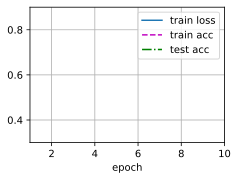

In [114]:
num_epochs = 10

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [116]:
W

tensor([[ 0.0213, -0.0314, -0.0028,  ...,  0.0034,  0.0151,  0.0178],
        [ 0.0277, -0.0466, -0.0201,  ...,  0.0022,  0.0026,  0.0297],
        [ 0.0125, -0.0321,  0.0081,  ...,  0.0146,  0.0142,  0.0249],
        ...,
        [ 0.0127, -0.0173, -0.0139,  ...,  0.0048,  0.0109,  0.0196],
        [ 0.0069, -0.0250,  0.0098,  ..., -0.0080,  0.0244,  0.0053],
        [ 0.0238, -0.0362,  0.0163,  ...,  0.0086,  0.0142,  0.0173]],
       requires_grad=True)

학습은 되나, 역시 정확도가 현저히 낮은 상태다

###MNIST dataset

In [36]:
trans = transforms.ToTensor()
train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [37]:
len(train), len(test)

(60000, 10000)

In [38]:
train[1]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

feature들과 label을 포함

In [39]:
X,y = next(iter(data.DataLoader(train, batch_size = 18)))

In [40]:
X.shape

torch.Size([18, 1, 28, 28])

굳이 text label 만들 필요없다.

숫자 classification이다

In [41]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

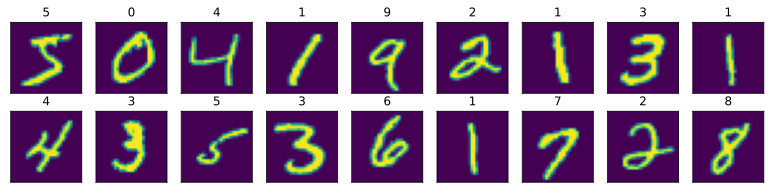

In [43]:

X,y = next(iter(data.DataLoader(train, batch_size = 18)))
show_images(X.reshape(18,28,28), 2, 9, titles = [int(i) for i in y])
plt.show()

Calling batches

In [44]:
def get_dataloader_workers(): ## 병렬 processing to read the data
  return 4

checking time of batch calling

In [45]:
batch_size = 300
train_iter = data.DataLoader(train, batch_size, shuffle = True,
                            num_workers = get_dataloader_workers())

timer = d2l.Timer()

for X, y in train_iter:
  continue

print(f'{timer.stop():.2f} sec')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


5.63 sec


batch load for MNIST dataset

In [46]:
def load_data_MNIST(batch_size, resize = None):

  trans = [transforms.ToTensor()]
  if resize:
        trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
 
  #MNIST dataset
  train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
  test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)
  
  return (data.DataLoader(train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [47]:
train_iter, test_iter = load_data_MNIST(18, resize = 64) # batch size = 18

for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([18, 1, 64, 64]) torch.float32 torch.Size([18]) torch.int64


####Softmax Regression from Scratch

In [49]:
batch_size = 300
train_iter, test_iter = load_data_MNIST(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [50]:
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([300, 1, 28, 28]) torch.float32 torch.Size([300]) torch.int64


#####initializing parameters


after gray transformation

feature flatten vector : 28X 28 = 784

X = 300X784

weight = 784X 10(classes)

bias = (1x10)

In [51]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0,0.01, size = (num_inputs, num_outputs), requires_grad = True)

b = torch.zeros(num_outputs, requires_grad = True)

In [52]:
W.shape

torch.Size([784, 10])

######Modeling

In [53]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1,keepdim = True)

  return X_exp / partition

def net(X):
  return softmax(torch.matmul(X.reshape((-1,W.shape[0])), W)+b) # reshape 조심

def cross_entropy(y_hat, y):
  return -torch.log(y_hat[range(len(y_hat)),y])
    #여기서 y_hat은 확률값(softmax 결과값)
    #정답에 해당하는 -log값
    #이후 다 더할 것임

reshape 쓸 때 조심

특히 net 함수 내에 있는 W는 global 변수 이기 때문에 다시 다른 데이터로 학습할 때는 다시 정의해줘야한다.

In [23]:
def accuracy(y_hat, y):

  if len(y_hat.shape) > 1 and y_hat.shape[1] >1: #2차원에 각 label에 대한 확률 값이 있음을 확신
    y_hat = y_hat.argmax(axis = 1) #제일 높은 값의 index

  cmp = y_hat.type(y.dtype) == y # compare class : dtype akwcnaustj
  return float(cmp.type(y.dtype).sum()) #맞는 개수 세기

class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]



def evaluate_accuracy(net, data_iter):

  if isinstance(net, torch.nn.Module):
    net.eval() # setting model to evaluation mode
  
  metric = Accumulator(2) 
  #two variables
  # number of correct predictions / number of predictions
  #accumulate sums over multiple variables

  with torch.no_grad():
    for X, y  in data_iter:
      
      metric.add(accuracy(net(X), y), y.numel())

  return metric[0] / metric[1] #최종 accuracy 평균값을 반환

#####Training

In [55]:
def train_epoch_ch3(net, train_iter, loss, updater):

  if isinstance(net, torch.nn.Module):
    net.train() # set train mode

  #sum of training loss / sum of trainig accruacy // number of examples
  metric = Accumulator(3)

  for X, y in  train_iter:

    #Compute gradients and update parameter
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):

      #backpropagation
      updater.zero_grad() # batch 돌때마다 가중치 변화도 초기화
      l.mean().backward()
      updater.step()

    else: # using custom built optimizer and loss criterion
      l.sum().backward()
      updater(X.shape[0])
    
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    #return trainig loss and training accuracy

    return metric[0] / metric[2], metric[1] / metric[2]

In [26]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [27]:
def train_ch3(net, trian_iter, test_iter, loss, num_epochs, updater):

  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
  
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, trian_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch +1, train_metrics + (test_acc,))
  
  train_loss, train_acc= train_metrics

  #조건 반환 문
  # assert train_loss < 0.5, train_loss
  # assert train_acc <=1 and train_acc >0.7, train_acc
  # assert test_acc<=1 and test_acc>0.7, test_acc
  print(train_loss, train_acc)
  

In [28]:
## updater 정의

lr = 0.2

def updater(batch_size):
  return d2l.sgd([W,b], lr, batch_size)

1.243650614420573 0.77


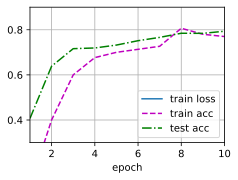

In [56]:

num_epochs = 10

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [57]:
W

tensor([[ 0.0089, -0.0150, -0.0070,  ..., -0.0071,  0.0081,  0.0031],
        [ 0.0155, -0.0052, -0.0166,  ...,  0.0021, -0.0026, -0.0017],
        [ 0.0125, -0.0124, -0.0070,  ..., -0.0038,  0.0071, -0.0060],
        ...,
        [-0.0153,  0.0011, -0.0048,  ...,  0.0011, -0.0126, -0.0179],
        [-0.0148, -0.0070, -0.0097,  ..., -0.0089, -0.0002,  0.0087],
        [ 0.0026,  0.0064, -0.0018,  ...,  0.0192,  0.0141, -0.0041]],
       requires_grad=True)

In [61]:
def predict_ch3(net, test_iter, n = 6):

    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = [int(i) for i in y]
    preds = [int(i) for i in net(X).argmax(axis=1)]
    titles = [str(true) +'\n' + str(pred) for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


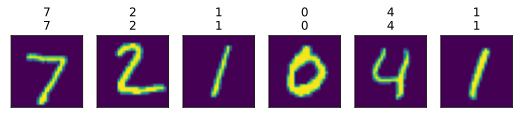

In [62]:
predict_ch3(net, test_iter)


####Using API

In [30]:
import torch
from torch import nn
from d2l import torch as d2l


In [95]:
batch_size = 300
train_iter, test_iter = load_data_MNIST(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#####Initialization

In [96]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784,10)) #flatten input layer + weight layer

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

#####Modeling

In [97]:
#loss
loss = nn.CrossEntropyLoss(reduction = "none")
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)

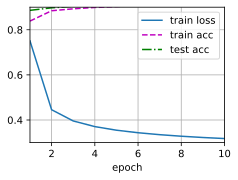

In [98]:
num_epochs = 10

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

###KMNIST

link : https://github.com/rois-codh/kmnist

일본 숫자 흐림체

####Scratch

In [68]:
trans = transforms.ToTensor()
train = torchvision.datasets.KMNIST(
    root="../data", train = True, transform=trans,
    download=True)
test = torchvision.datasets.KMNIST(
    root="../data", train = False, transform=trans,
    download=True)

In [69]:
len(train), len(test)

(60000, 10000)

In [70]:
train[0][0].shape

torch.Size([1, 28, 28])

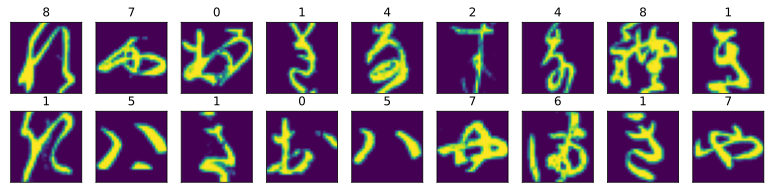

In [71]:
X,y = next(iter(data.DataLoader(train, batch_size = 18)))
show_images(X.reshape(18,28,28), 2, 9, titles = [int(i) for i in y])
plt.show()

In [72]:
def get_dataloader_workers(): ## 병렬 processing to read the data
  return 4

def load_data_KMNIST(batch_size, resize = None):

  trans = [transforms.ToTensor()]
  if resize:
        trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
 
  #KMNIST dataset

  train = torchvision.datasets.KMNIST(
    root="../data", train = True, transform=trans,
    download=True)
  test = torchvision.datasets.KMNIST(
    root="../data", train = False, transform=trans,
    download=True)
  
  return (data.DataLoader(train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [87]:
batch_size = 300
train_iter, test_iter = load_data_KMNIST(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [88]:
num_inputs = 28*28
num_outputs = 10

W = torch.normal(0,0.01, size = (num_inputs, num_outputs), requires_grad = True)

b = torch.zeros(num_outputs, requires_grad = True)

In [75]:
W.shape

torch.Size([784, 10])

#####modeling

In [89]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1,keepdim = True)

  return X_exp / partition

def net(X):
  return softmax(torch.matmul(X.reshape((-1,W.shape[0])), W)+b) # reshape 조심

def cross_entropy(y_hat, y):
  return -torch.log(y_hat[range(len(y_hat)),y])
    #여기서 y_hat은 확률값(softmax 결과값)
    #정답에 해당하는 -log값
    #이후 다 더할 것임


def accuracy(y_hat, y):

  if len(y_hat.shape) > 1 and y_hat.shape[1] >1: #2차원에 각 label에 대한 확률 값이 있음을 확신
    y_hat = y_hat.argmax(axis = 1) #제일 높은 값의 index

  cmp = y_hat.type(y.dtype) == y # compare class : dtype akwcnaustj
  return float(cmp.type(y.dtype).sum()) #맞는 개수 세기

class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]



def evaluate_accuracy(net, data_iter):

  if isinstance(net, torch.nn.Module):
    net.eval() # setting model to evaluation mode
  
  metric = Accumulator(2) 
  #two variables
  # number of correct predictions / number of predictions
  #accumulate sums over multiple variables

  with torch.no_grad():
    for X, y  in data_iter:
      
      metric.add(accuracy(net(X), y), y.numel())

  return metric[0] / metric[1] #최종 accuracy 평균값을 반환

In [90]:
def train_epoch_ch3(net, train_iter, loss, updater):

  if isinstance(net, torch.nn.Module):
    net.train() # set train mode

  #sum of training loss / sum of trainig accruacy // number of examples
  metric = Accumulator(3)

  for X, y in  train_iter:

    #Compute gradients and update parameter
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):

      #backpropagation
      updater.zero_grad() # batch 돌때마다 가중치 변화도 초기화
      l.mean().backward()
      updater.step()

    else: # using custom built optimizer and loss criterion
      l.sum().backward()
      updater(X.shape[0])
    
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    #return trainig loss and training accuracy

    return metric[0] / metric[2], metric[1] / metric[2]

In [91]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
           if a is not None and b is not None:
             self.X[i].append(a)
             self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
          self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [92]:
def train_ch3(net, trian_iter, test_iter, loss, num_epochs, updater):

  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
  
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, trian_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch +1, train_metrics + (test_acc,))
  
  train_loss, train_acc= train_metrics

  #조건 반환 문
  # assert train_loss < 0.5, train_loss
  # assert train_acc <=1 and train_acc >0.7, train_acc
  # assert test_acc<=1 and test_acc>0.7, test_acc
  print(train_loss, train_acc)
  return

In [93]:
lr = 0.3

def updater(batch_size):
  return d2l.sgd([W,b], lr, batch_size)

#####Training

**중요 **

학습 모델을 만들 때, 사용자 정의 함수를 사용하는데, 

global 변수를 많이 사용한다.

다른 데이터로 이미 사용한 함수는 다시 재정의해서 사용해야한다.

1.2732240804036459 0.6733333333333333


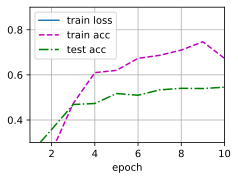

In [94]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

#####Prediction

In [82]:
def predict_ch3(net, test_iter, n = 6):

    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = [int(i) for i in y]
    preds = [int(i) for i in net(X).argmax(axis=1)]
    titles = [str(true) +'\n' + str(pred) for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


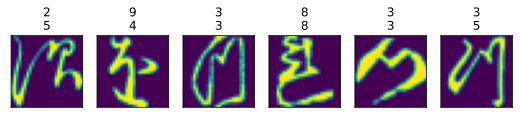

In [83]:
predict_ch3(net, test_iter,n = 6)

####API

In [84]:
batch_size = 300
train_iter, test_iter = load_data_KMNIST(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [85]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784,10)) #flatten input layer + weight layer

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

AssertionError: ignored

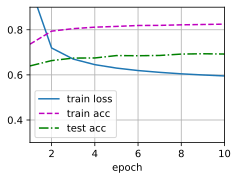

In [86]:
loss = nn.CrossEntropyLoss(reduction = "none")
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)
num_epochs = 10

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

train_loss가 0.5보다 크게 나와서 error문 raise